**Лабораторная работа №6**

In [ ]:
!pip install kaggle
!pip install pandas
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu118
!kaggle datasets download -d shuvoalok/raf-db-dataset -p data --unzip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d shuvoalok/raf-db-dataset -p data --unzip

Saving kaggle.json to kaggle.json
ref                                                          title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
jayaantanaath/student-habits-vs-academic-performance         Student Habits vs Academic Performance                  19512  2025-04-12 10:49:08.663000          16994        295  1.0              
umeradnaan/daily-social-media-active-users                   Daily Social Media Active Users                        126814  2025-05-05 02:11:50.873000           1139         21  1.0              
fatemehmohammadinia/heart-attack-dataset-tarik-a-rashid      Heart Attack Dataset                                    16250  2025-04-30 21:58:22.740000           2864         48  1.0 

### 1. Подготовка и статистика данных
## а. Набор данных
В этом блоке:
- Задаются базовые гиперпараметры:
  - `IMG_SIZE = 112` – размер изображений после ресайза  
  - `BATCH_SIZE = 32`  
  - `VAL_SPLIT = 0.10` – доля валидационной выборки  
- Описываются аугментации и нормализация для тренировочного и валидационного датасетов:
  - случайный флип, поворот до ±15°  
  - преобразование в тензор и нормализация по каналам с `mean=0.5, std=0.5`  
- Загружается полный тренировочный датасет через `ImageFolder`
- Разбивается на тренировочную и валидационную части (90%/10%) с фиксированным `seed=42`
- Создаются `DataLoader`-ы для train/val/test с `num_workers=4`
- Выводится статистика:  
  - список классов  
  - число изображений в каждом наборе  
  - распределение по классам в тренировочной выборке  


In [ ]:
import os
from collections import Counter

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


DATA_DIR  = "data/DATASET"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")

# ---- аугментации и нормализация (RGB) ---------------------------------------

train_tf = transforms.Compose([
    transforms.Resize(112),              # RAF-DB хранится 100×100 → чуть крупнее
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

val_tf = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

# ---- загрузка датасета ------------------------------------------------------

full_train_ds = datasets.ImageFolder(root=TRAIN_DIR, transform=train_tf)

# делим train на train/val (10 % под валидацию)
val_size   = int(0.10 * len(full_train_ds))
train_size = len(full_train_ds) - val_size
train_ds, val_ds = random_split(
    full_train_ds,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # фиксируем для воспроизводимости
)

test_ds = datasets.ImageFolder(root=TEST_DIR, transform=val_tf)

# ---- DataLoader-ы -----------------------------------------------------------

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=4)

# ---- сводная статистика -----------------------------------------------------

print("классы  –", full_train_ds.classes)
print("картинок в train:", len(train_ds))
print("картинок в val:  ", len(val_ds))
print("картинок в test: ", len(test_ds))

# распределение классов внутри трен-подвыборки
train_labels   = [full_train_ds.targets[i] for i in train_ds.indices]
class_counts   = Counter(train_labels)
for cls_idx, cnt in sorted(class_counts.items()):
    print(f"{full_train_ds.classes[cls_idx]:<10s}: {cnt}")


классы  – ['1', '2', '3', '4', '5', '6', '7']
картинок в train: 11044
картинок в val:   1227
картинок в test:  3068
1         : 1155
2         : 256
3         : 633
4         : 4306
5         : 1791
6         : 644
7         : 2259


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### 2.Создание бейзлайна и оценка качества

В этом блоке мы визуализируем несколько примеров и создаим бейзлайн с оценкой качества из тренировочного набора, чтобы убедиться в корректности загрузки и в том, как выглядят исходные данные:

- **Гиперпараметры и пути**  
  - `DATA_DIR = "data/DATASET"` – корневая папка с данными  
  - `TRAIN_DIR` и `TEST_DIR` — поддиректории для тренировочных и тестовых изображений  

- **Преобразования для показа (`show_tf`)**  
  - `Resize(112)` — приводим все изображения к размеру 112×112  
  - `ToTensor()` — переводим в диапазон [0,1] для корректного отображения без искажений цвета  

- **Датасет для просмотра**  
  - `show_data = ImageFolder(TRAIN_DIR, transform=show_tf)` — загружаем тренировочный набор без нормализации  

- **Функция `imshow()`**  
  - Принимает тензор формы `[3, H, W]` в диапазоне [0,1]  
  - Переставляет каналы в формат `[H, W, 3]` и отображает через `matplotlib`  

- **Отображение 5 случайных примеров**  
  - Используем первые 5 элементов из `show_data` (можно заменить на случайные индексы)  
  - Показываем изображение и подписываем класс (`show_data.classes[label]`)  
  - Отключаем оси для наглядности  


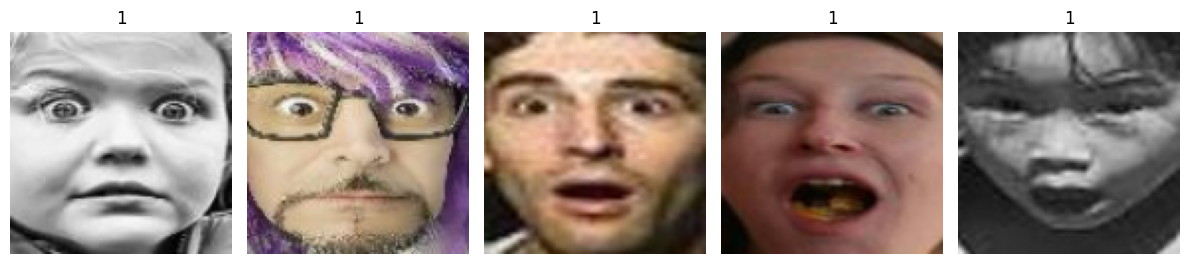

In [ ]:
import os, matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

# ---------- директории ----------
DATA_DIR  = "data/DATASET"          # запомнили :)
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")

# ---------- набор только для показа ----------
#  * без нормализации, чтобы цвета не «съехали»
show_tf = transforms.Compose([
    transforms.Resize(112),        # подгоняем одинаковый размер
    transforms.ToTensor()          # 0-1, 3 × H × W
])
show_data = datasets.ImageFolder(TRAIN_DIR, transform=show_tf)

# ---------- функция-обёртка ----------
def imshow(img_tensor):
    """Отобразить RGB-тензор [0,1], H × W × 3."""
    img = img_tensor.permute(1, 2, 0).numpy()   # CHW → HWC
    plt.imshow(np.clip(img, 0, 1))
    plt.axis("off")

# ---------- вывод пяти случайных изображений ----------
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    img, label = show_data[i]                   # i-й элемент из train/
    axes[i].imshow(img.permute(1, 2, 0))        # уже [0,1] → можно сразу
    axes[i].set_title(show_data.classes[label]) # '0_angry', '1_disgust', …
    axes[i].axis("off")

plt.tight_layout()
plt.show()


### 3. Подготовка данных и DataLoader-ы для CNN и ViT

В этом блоке мы конфигурируем преобразования, загружаем датасеты и создаём загрузчики данных для двух типов моделей — обычной сверточной сети (ResNet-18) и трансформера (ViT):

- **Устройство для вычислений**  
  - `device = torch.device("cuda" if torch.cuda.is_available() else "cpu")`  
    Определяем, будет ли обучение на GPU или CPU.  

- **Преобразования (Transforms)**  
  - **`cnn_transform`** (для ResNet-18):  
    - `Resize((224,224))` — масштабируем изображения до 224×224 пикселей  
    - `ToTensor()` + `Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])` — приводим значения каналов в диапазон примерно [−1,1]  
  - **`vit_transform`** (для ViT):  
    - `Resize((224,224))` — тот же размер для входа в Vision Transformer  
    - `ToTensor()` + `Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])` — стандартная нормализация ImageNet  

- **Формирование обучающего и валидационного наборов**  
  - `full_train_cnn` и `full_train_vit` — два `ImageFolder` с разными трансформациями  
  - Разбиение на train/val в соотношении 80 %/20 % с помощью `random_split(..., generator=seed=42)` для воспроизводимости  

- **Тестовый набор**  
  - `test_ds_cnn` и `test_ds_vit` — отдельные `ImageFolder` для оценки на отложенных данных  

- **DataLoader-ы**  
  - `train_loader`, `val_loader`, `test_loader` для CNN  
  - `train_loader_vit`, `val_loader_vit`, `test_loader_vit` для ViT  
  - Используем `batch_size=32`, перемешивание (`shuffle=True`) только для тренировочных данных, остальным — `shuffle=False`  

- **Количество классов**  
  - `num_classes = len(full_train_cnn.classes)` — автоматически определяем число категорий (в RAF-DB их 7)


In [ ]:
import os, torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18, vit_b_16
import torch.nn as nn
import torch.optim as optim

# ---------- устройство ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# ---------- директории ----------
DATA_DIR  = "data/DATASET"          # корень
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")

# ---------- трансформации ----------
# для обычных CNN (ResNet-18 и т. д.)
cnn_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

# для ViT (используем те же mean/std, что в ImageNet-pretrain)
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ---------- наборы данных ----------
full_train_cnn = datasets.ImageFolder(TRAIN_DIR, transform=cnn_transform)
full_train_vit = datasets.ImageFolder(TRAIN_DIR, transform=vit_transform)

# делаем сплит train / val (80 / 20) ─ RAF-DB не имеет отдельной валидации
val_fraction = 0.20
train_len = int((1 - val_fraction) * len(full_train_cnn))
val_len   = len(full_train_cnn) - train_len

train_ds_cnn,  val_ds_cnn  = random_split(full_train_cnn, [train_len, val_len],
                                          generator=torch.Generator().manual_seed(42))
train_ds_vit,  val_ds_vit  = random_split(full_train_vit, [train_len, val_len],
                                          generator=torch.Generator().manual_seed(42))

test_ds_cnn = datasets.ImageFolder(TEST_DIR, transform=cnn_transform)
test_ds_vit = datasets.ImageFolder(TEST_DIR, transform=vit_transform)

# ---------- dataloader-ы ----------
batch_size = 32
train_loader      = DataLoader(train_ds_cnn, batch_size=batch_size, shuffle=True)
val_loader        = DataLoader(val_ds_cnn,   batch_size=batch_size, shuffle=False)
test_loader       = DataLoader(test_ds_cnn,  batch_size=batch_size, shuffle=False)

train_loader_vit  = DataLoader(train_ds_vit, batch_size=batch_size, shuffle=True)
val_loader_vit    = DataLoader(val_ds_vit,   batch_size=batch_size, shuffle=False)
test_loader_vit   = DataLoader(test_ds_vit,  batch_size=batch_size, shuffle=False)

# ---------- число классов ----------
num_classes = len(full_train_cnn.classes)   # в RAF-DB их 7
print("num_classes:", num_classes)


device: cuda
num_classes: 7


## 4. Улучшение бейзлайна

В этом блоке мы инициализируем предобученную ResNet-18, настраиваем её под нашу задачу классификации RAF-DB и реализуем цикл обучения:

- **Модель ResNet-18**  
  - `resnet18(weights="IMAGENET1K_V1")` — загружаем предобученные на ImageNet веса  
  - Перенастраиваем последний полносвязный слой:  
    ```python
    model_cnn.fc = nn.Linear(model_cnn.fc.in_features, num_classes)
    ```  
    где `num_classes = 7` для семи эмоций RAF-DB  

- **Критерий и оптимизатор**  
  - `criterion = nn.CrossEntropyLoss()` — стандартная кросс-энтропия для многоклассовой классификации  
  - `optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)` — адаптивный оптимизатор с умеренной скоростью обучения  

- **Цикл обучения `train_model()`**  
  1. **Режим обучения** (`model.train()`) и обнуление градиентов  
  2. **Прямой проход**:  
     ```python
     outputs = model(images)
     loss = criterion(outputs, labels)
     ```  
  3. **Обратный проход и шаг оптимизатора** (`loss.backward(); optimizer.step()`)  
  4. **Агрегация метрик**  
     - `train_loss` — средний лосс по батчам  
     - `train_acc` — точность на тренировочном наборе  
  5. При наличии `val_loader` — вычисляем `val_acc` в режиме валидации (`model.eval()`, `torch.no_grad()`)  

- **Вывод прогресса**  
  - По батчам выводим номер текущего шага  
  - По эпохам печатаем:  
    ```
    epoch {i}: loss={train_loss:.4f} │ train_acc={train_acc:.4f} │ val_acc={val_acc:.4f}
    ```


In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torchvision.models import resnet18

# ─── базовые сущности ─────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7                                  # RAF-DB

# ─── модель ────────────────────────────────────────────────────────────────────
model_cnn = resnet18(weights="IMAGENET1K_V1")    # pretrained=True (новый API)
model_cnn.fc = nn.Linear(model_cnn.fc.in_features, num_classes)
model_cnn.to(device)

criterion  = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model_cnn.parameters(), lr=1e-3)  # 0.01 великоват

# ─── цикл обучения ────────────────────────────────────────────────────────────
def train_model(model, train_loader, val_loader=None, optimizer=None, epochs=3):
    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0.0, 0

        for step, (images, labels) in enumerate(train_loader, 1):
            if step % 250 == 1 or step == len(train_loader):
                print(f"epoch {epoch+1} — batch {step}/{len(train_loader)}")

            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss    = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss   += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_acc  = total_correct / len(train_loader.dataset)

        # валидация (если передана)
        if val_loader is not None:
            model.eval()
            val_correct = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    val_correct += (model(images).argmax(1) == labels).sum().item()
            val_acc = val_correct / len(val_loader.dataset)
            print(f"epoch {epoch+1}: loss={train_loss:.4f} │ "
                  f"train_acc={train_acc:.4f} │ val_acc={val_acc:.4f}")
        else:
            print(f"epoch {epoch+1}: loss={train_loss:.4f} │ "
                  f"train_acc={train_acc:.4f} │ val_acc=—")



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.8MB/s]


In [ ]:
train_model(model_cnn, train_loader, val_loader, optimizer, epochs=5)


epoch 1 — batch 1/307
epoch 1 — batch 251/307
epoch 1 — batch 307/307
epoch 1: loss=0.9896 │ train_acc=0.6500 │ val_acc=0.6656
epoch 2 — batch 1/307
epoch 2 — batch 251/307
epoch 2 — batch 307/307
epoch 2: loss=0.6963 │ train_acc=0.7530 │ val_acc=0.7507
epoch 3 — batch 1/307
epoch 3 — batch 251/307
epoch 3 — batch 307/307
epoch 3: loss=0.5566 │ train_acc=0.8053 │ val_acc=0.7532
epoch 4 — batch 1/307
epoch 4 — batch 251/307
epoch 4 — batch 307/307
epoch 4: loss=0.4441 │ train_acc=0.8418 │ val_acc=0.7523
epoch 5 — batch 1/307
epoch 5 — batch 251/307
epoch 5 — batch 307/307
epoch 5: loss=0.3620 │ train_acc=0.8769 │ val_acc=0.7739


## 5. Инициализация модели ViT-B/16

В этом блоке мы готовим архитектуру Vision Transformer (ViT-B/16) для задачи классификации эмoций:

- **Загрузка предобученных весов**  
  - `ViT_B_16_Weights.IMAGENET1K_V1` — официальные веса, обученные на ImageNet1K  

- **Создание модели**  
  - `model_vit = vit_b_16(weights=weights)` — загружаем ViT-B/16 с предобученными параметрами  

- **Переопределение классификационной головы**  
  - `model_vit.heads.head = nn.Linear(..., num_classes)`  
  — заменяем последний полносвязный слой под наше число классов (`num_classes = 7`)  

- **Перенос на устройство**  
  - `model_vit.to(device)` — модель на GPU (если доступен) или на CPU  

- **Оптимизатор**  
  - `optimizer_vit = optim.SGD(..., lr=1e-3, momentum=0.9)`  
  — используем стохастический градиентный спуск с моментацией для более стабильного обновления весов  


In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torchvision.models import vit_b_16, ViT_B_16_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── модель ViT-B/16 с ImageNet-весами ────────────────────────────────────────
weights   = ViT_B_16_Weights.IMAGENET1K_V1    # заменяет устаревшее pretrained=True
model_vit = vit_b_16(weights=weights)

# меняем «голову» под 7 классов RAF-DB
model_vit.heads.head = nn.Linear(model_vit.heads.head.in_features, num_classes)
model_vit.to(device)

# ─── оптимизатор ──────────────────────────────────────────────────────────────
optimizer_vit = optim.SGD(model_vit.parameters(), lr=1e-3, momentum=0.9)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 66.3MB/s]


In [ ]:
train_model(model_vit, train_loader_vit, None, optimizer=optimizer_vit, epochs=3)


epoch 1 — batch 1/307
epoch 1 — batch 251/307
epoch 1 — batch 307/307
epoch 1: loss=1.1177 │ train_acc=0.5994 │ val_acc=—
epoch 2 — batch 1/307
epoch 2 — batch 251/307
epoch 2 — batch 307/307
epoch 2: loss=0.6969 │ train_acc=0.7508 │ val_acc=—
epoch 3 — batch 1/307
epoch 3 — batch 251/307
epoch 3 — batch 307/307
epoch 3: loss=0.5231 │ train_acc=0.8144 │ val_acc=—


## 6. Аугментации и загрузка тренировочных данных

В этом блоке мы описываем, как готовятся данные для обучения моделей CNN (ResNet) и ViT:

- **Пути к данным**  
  - `DATA_DIR = "data/DATASET"` — корневая папка с набором RAF-DB  
  - `TRAIN_DIR` — поддиректория с тренировочными изображениями  

- **Аугментации для CNN (ResNet-18 и др.)**  
  1. `RandomHorizontalFlip()` — случайный горизонтальный флип  
  2. `RandomRotation(10)` — случайный поворот в пределах ±10°  
  3. `RandomResizedCrop(224, scale=(0.9,1.0))` — центрированный или случайный кроп до 224×224, масштаб от 90% до 100%  
  4. `ToTensor()` — преобразование в тензор  
  5. `Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])` — нормализация на нулевое среднее и единичное отклонение  

- **Аугментации для ViT (ViT-B/16)**  
  1. `Resize(256)` — масштабирование меньшей стороны до 256 пикселей  
  2. `RandomResizedCrop(224, scale=(0.9,1.0))` — обрезка до 224×224, масштаб от 90% до 100%  
  3. `RandomHorizontalFlip()`, `RandomRotation(10)` — те же геометрические аугментации  
  4. `ToTensor()`  
  5. `Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])` — статистика ImageNet для предобученных ViT  

- **Создание датасетов**  
  - `train_data = ImageFolder(TRAIN_DIR, transform=train_transform)`  
  - `train_data_vit = ImageFolder(TRAIN_DIR, transform=vit_transform)`  

- **DataLoader для обучения**  
  - `batch_size = 32` — размер одного мини-пакета  
  - `shuffle=True` — перемешивание данных перед каждой эпохой  
  - `num_workers=2` — количество потоков для загрузки (можно увеличить при достаточных ресурсах CPU)  
  - `pin_memory=True` — ускоряет передачу тензоров в GPU при использовании CUDA  


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ─────────────────────────── директории RAF-DB ────────────────────────────────
DATA_DIR  = "data/DATASET"
TRAIN_DIR = os.path.join(DATA_DIR, "train")

# ──────────────────────── аугментации для CNN-моделей ─────────────────────────
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],        # RGB → 3 канала
                         [0.5, 0.5, 0.5])
])

# ───────────────────────── аугментации для ViT ────────────────────────────────
vit_transform = transforms.Compose([
    transforms.Resize(256),                      # чуть больше, потом кроп
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet-статистика
                         std=[0.229, 0.224, 0.225])
])

# ─────────────────────────── наборы данных ───────────────────────────────────
train_data      = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
train_data_vit  = datasets.ImageFolder(TRAIN_DIR, transform=vit_transform)

# ─────────────────────────── DataLoader-ы ─────────────────────────────────────
batch_size  = 32
num_workers = 2

train_loader      = DataLoader(train_data,     batch_size=batch_size,
                               shuffle=True,   num_workers=num_workers,
                               pin_memory=True)

train_loader_vit  = DataLoader(train_data_vit, batch_size=batch_size,
                               shuffle=True,   num_workers=num_workers,
                               pin_memory=True)


In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7        # для RAF-DB

# ─── модель ───────────────────────────────────────────────────────────────────
weights = ResNet18_Weights.IMAGENET1K_V1       # эквивалент прежнему pretrained=True
model   = resnet18(weights=weights)

model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

# ─── оптимизатор / критерий ───────────────────────────────────────────────────
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion  = nn.CrossEntropyLoss()


### 7. Функция обучения модели (`train_model`)
### Имплементация алгоритма машинного обучения
Эта универсальная функция инкапсулирует процесс обучения и (опционально) валидации любой классификационной модели PyTorch:

- **Аргументы**  
  - `model` — ваша PyTorch-модель  
  - `train_loader` — `DataLoader` для обучающей выборки  
  - `val_loader` (по умолчанию `None`) — `DataLoader` для валидации; если не задан, валидация пропускается  
  - `optimizer` — оптимизатор (например, Adam, SGD)  
  - `criterion` (по умолчанию `nn.CrossEntropyLoss()`) — функция потерь  
  - `scheduler` (по умолчанию `None`) — планировщик обучения; если задан, вызывается `scheduler.step()` после каждой эпохи  
  - `epochs: int` — число эпох обучения  

- **Логика работы**  
  1. **Инициализация критерия потерь**  
     Если `criterion` не передан, используется `CrossEntropyLoss`.  
  2. **Цикл по эпохам**  
     - Перевод модели в режим `train()`.  
     - Итерация по пакетам из `train_loader`:  
       - Печать прогресса каждые 250 батчей.  
       - Прямой проход (`logits = model(images)`) → вычисление `loss` → обратное распространение → шаг оптимизатора.  
       - Накопление суммы потерь и числа правильно классифицированных примеров.  
     - Подсчёт **средней** потери (`train_loss`) и **точности** (`train_acc`) на тренировочной выборке.  
  3. **(Опционально) Валидация**  
     Если передан `val_loader`, модель переводится в `eval()` и без градиентов вычисляется точность на валидационной выборке (`val_acc`).  
  4. **Шаг планировщика LR**  
     Если `scheduler` не `None`, вызывается `scheduler.step()` в конце каждой эпохи.  

- **Вывод в консоль**  
  - Для каждой эпохи печатается:  
    ```
    epoch X: loss={train_loss:.4f} │ train_acc={train_acc:.4f} │ val_acc={val_acc:.4f}
    ```  
    или, если `val_loader` не задан:  
    ```
    epoch X: loss={train_loss:.4f} │ train_acc={train_acc:.4f} │ val_acc=—
    ```  


In [ ]:
def train_model(model,
                train_loader,
                val_loader=None,
                optimizer=None,
                criterion=None,
                scheduler=None,
                epochs: int = 5):
    """
    Обучение модели.
    - scheduler   — опционален; если None, шаг не вызывается.
    - val_loader  — можно передать None, тогда валидация пропускается.
    """
    if criterion is None:
        criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        # ────────── TRAIN ──────────
        model.train()
        run_loss, run_correct = 0.0, 0

        for step, (images, labels) in enumerate(train_loader, 1):
            if step % 250 == 1 or step == len(train_loader):
                print(f"epoch {epoch} — batch {step}/{len(train_loader)}")

            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(images)
            loss   = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            run_loss   += loss.item()
            run_correct += (logits.argmax(1) == labels).sum().item()

        train_loss = run_loss / len(train_loader)
        train_acc  = run_correct / len(train_loader.dataset)

        # ────────── VAL (если есть) ──────────
        if val_loader is not None:
            model.eval()
            val_correct = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    logits = model(images.to(device))
                    val_correct += (logits.argmax(1).cpu() == labels).sum().item()
            val_acc = val_correct / len(val_loader.dataset)
            print(f"epoch {epoch}: loss={train_loss:.4f} │ "
                  f"train_acc={train_acc:.4f} │ val_acc={val_acc:.4f}")
        else:
            print(f"epoch {epoch}: loss={train_loss:.4f} │ "
                  f"train_acc={train_acc:.4f} │ val_acc=—")

        # шаг LR-scheduler’а (если передан)
        if scheduler is not None:
            scheduler.step()


In [ ]:
train_model(model, train_loader, None, optimizer=optimizer, epochs=5)


epoch 1 — batch 1/384
epoch 1 — batch 251/384
epoch 1 — batch 384/384
epoch 1: loss=1.0760 │ train_acc=0.6145 │ val_acc=—
epoch 2 — batch 1/384
epoch 2 — batch 251/384
epoch 2 — batch 384/384
epoch 2: loss=0.7940 │ train_acc=0.7180 │ val_acc=—
epoch 3 — batch 1/384
epoch 3 — batch 251/384
epoch 3 — batch 384/384
epoch 3: loss=0.6981 │ train_acc=0.7532 │ val_acc=—
epoch 4 — batch 1/384
epoch 4 — batch 251/384
epoch 4 — batch 384/384
epoch 4: loss=0.6352 │ train_acc=0.7799 │ val_acc=—
epoch 5 — batch 1/384
epoch 5 — batch 251/384
epoch 5 — batch 384/384
epoch 5: loss=0.5886 │ train_acc=0.7962 │ val_acc=—


In [ ]:
model_vit = vit_b_16(pretrained=True)
model_vit.heads.head = nn.Linear(model_vit.heads.head.in_features, len(train_data.classes))
model_vit.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_vit = optim.SGD(model_vit.parameters(), lr=0.0001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_model(model_vit, train_loader_vit, None, optimizer=optimizer_vit, epochs=3)


epoch 1 — batch 1/384
epoch 1 — batch 251/384
epoch 1 — batch 384/384
epoch 1: loss=1.4967 │ train_acc=0.4523 │ val_acc=—
epoch 2 — batch 1/384
epoch 2 — batch 251/384
epoch 2 — batch 384/384
epoch 2: loss=1.2020 │ train_acc=0.5791 │ val_acc=—
epoch 3 — batch 1/384
epoch 3 — batch 251/384
epoch 3 — batch 384/384
epoch 3: loss=1.0054 │ train_acc=0.6471 │ val_acc=—


### 8. Определение пользовательской CNN-модели (`MyCNN`)

В этом блоке мы описываем компактную сверточную нейронную сеть для классификации:

- **Класс `MyCNN(nn.Module)`**  
  - Принимает на вход `num_classes` — число выходных категорий (для RAF-DB это 7).  
  - Вызывает `super().__init__()` для корректной инициализации родительского класса.

- **Блок признаков (`self.features`)**  
  Последовательность из 3 сверточных блоков, каждый из которых содержит:  
  1. `Conv2d` (3→32, 32→64, 64→128; ядро 3×3, padding=1)  
  2. `ReLU(inplace=True)` — нелинейность  
  3. `BatchNorm2d` — нормализация  
  4. `MaxPool2d(2)` — понижение разрешения в 2 раза  

- **Глобальный пуллинг (`self.gap`)**  
  - `AdaptiveAvgPool2d(1)` превращает выход [B, 128, H, W] → [B, 128, 1, 1], усредняя по пространственным осям.

- **Классификационная «голова» (`self.head`)**  
  1. `Flatten()` → преобразует [B, 128, 1, 1] → [B, 128]  
  2. `Dropout(0.4)` — регуляризация  
  3. `Linear(128, num_classes)` — финальный полносвязный слой  

- **Метод `forward(x)`**  
  1. Пропускает вход через `self.features`  
  2. Применяет `self.gap`  
  3. Отправляет результат в `self.head` и возвращает логиты для каждого класса  


In [ ]:
class MyCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  nn.ReLU(inplace=True), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64,128, 3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(128), nn.MaxPool2d(2)
        )
        self.gap   = nn.AdaptiveAvgPool2d(1)   # → [B,128,1,1]
        self.head  = nn.Sequential(
            nn.Flatten(),                      # → [B,128]
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        return self.head(x)

### 9. Определение собственной трансформерной модели (`MyViT`)

В этом блоке реализуется облегчённая версия Vision Transformer:

- **Класс `PatchEmbedding`**  
  - Разбивает входное изображение на неперекрывающиеся патчи размера `patch_size × patch_size` с помощью 2D-свертки (`kernel_size=patch_size, stride=patch_size`).  
  - Проецирует каждый патч в вектор размерности `emb_size`.  
  - Добавляет специальный `[CLS]`-токен в начало последовательности и учит его вместе с позиционными эмбеддингами (`pos_emb`), инициализированными по нормальному закону (truncated normal).

- **Класс `TransformerEncoder`**  
  - Одна «голова» самовнимания (`MultiheadAttention`) с `heads` параллельными проекциями.  
  - Два слоя нормализации (`LayerNorm`) и два остаточных соединения:  
    1. Сумма входа + выход самовнимания → `norm1`  
    2. Сумма результата + выход MLP-блока → `norm2`  
  - Внутренний MLP-блок (`ff`): линейный слой → GELU → Dropout → линейный слой.

- **Класс `MyViT`**  
  1. **Patch Embedding**  
     - Вызывает `PatchEmbedding`, чтобы получить тензор формы `(B, N+1, E)` (где `N` = число патчей, `+1` за счёт `[CLS]`).  
  2. **Последовательность Transformer-блоков**  
     - Стек из `depth` экземпляров `TransformerEncoder`.  
  3. **MLP-голова**  
     - Нормализация выходного эмбеддинга класса (`LayerNorm`)  
     - Линейный слой `(emb_size → num_classes)`  
  4. **Метод `forward(x)`**  
     - Генерирует последовательность патч-эмбеддингов, прогоняет её через все блоки и возвращает логиты, соответствующие первому токену (`[CLS]`).

Эта архитектура сочетает в себе идею разбивки изображения на патчи и стандартный трансформерный энкодер, что позволяет обучать модель на небольших объёмах данных без слишком большого числа параметров.


In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torch.cuda.amp import autocast, GradScaler

# ───────────────────────── Patch + PosEmb ──────────────────────────
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16,
                 in_channels=3, emb_size=256):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, emb_size,
                              kernel_size=patch_size,
                              stride=patch_size)          # (B, C, H, W) → (B, E, h, w)

        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_size))
        self.pos_emb   = nn.Parameter(torch.zeros(1, num_patches + 1, emb_size))

        nn.init.trunc_normal_(self.pos_emb, std=0.02)      # ← init как в ViT
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B = x.size(0)
        x = self.proj(x).flatten(2).transpose(1, 2)        # (B, E, h, w) → (B, N, E)
        cls = self.cls_token.expand(B, -1, -1)             # (B,1,E)
        x = torch.cat((cls, x), dim=1)                     # prepend [CLS]
        return x + self.pos_emb

# ───────────────────────── Transformer block ───────────────────────
class TransformerEncoder(nn.Module):
    def __init__(self, emb_size=256, heads=4, mlp_ratio=4., dropout=0.1):
        super().__init__()
        self.attn  = nn.MultiheadAttention(emb_size, heads, dropout=dropout,
                                           batch_first=True)
        self.norm1 = nn.LayerNorm(emb_size)
        self.norm2 = nn.LayerNorm(emb_size)

        self.ff = nn.Sequential(
            nn.Linear(emb_size, int(emb_size * mlp_ratio)),
            nn.GELU(),                                    # GELU как в оригинале
            nn.Dropout(dropout),
            nn.Linear(int(emb_size * mlp_ratio), emb_size)
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x, need_weights=False)
        x = self.norm1(x + self.drop(attn_out))
        x = self.norm2(x + self.drop(self.ff(x)))
        return x

# ───────────────────────── ViT mini ────────────────────────────────
class MyViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16,
                 in_channels=3, num_classes=7,
                 emb_size=256, depth=6, heads=4):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size,
                                          in_channels, emb_size)
        self.blocks = nn.Sequential(*[
            TransformerEncoder(emb_size, heads) for _ in range(depth)
        ])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, num_classes)
        )

    def forward(self, x):
        x = self.patch_embed(x)      # (B, N+1, E)
        x = self.blocks(x)           # (B, N+1, E)
        return self.mlp_head(x[:, 0])  # берём [CLS]



In [ ]:
cnn_model = MyCNN(num_classes=len(train_data.classes)).to(device)
vit_model = MyViT(num_classes=len(train_data.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001)
optimizer_vit = optim.SGD(vit_model.parameters(), lr=0.001, momentum=0.9)


### 8. Функция обучения `train_model`

Этот блок содержит универсальную функцию для тренировки любой классификационной модели в PyTorch:

- **Параметры функции**  
  - `model` — любая `nn.Module`, которую нужно обучить.  
  - `train_loader` — `DataLoader` для обучающей выборки.  
  - `val_loader` (опционально) — `DataLoader` для валидации; если `None`, этап валидации пропускается.  
  - `optimizer` — оптимизатор (например, `Adam`, `SGD`).  
  - `criterion` (опционально) — функция потерь; по умолчанию `nn.CrossEntropyLoss()`.  
  - `scheduler` (опционально) — планировщик скорости обучения; вызывается `scheduler.step()` после каждой эпохи.  
  - `epochs` — число эпох обучения (по умолчанию 3).

- **Структура цикла**  
  1. **Инициализация критерия**  
     - Если `criterion` не передан, используется `CrossEntropyLoss`.  
  2. **Эпохи**  
     - Устанавливаем модель в режим `train()`.  
     - Сбрасываем накопители потерь и точности (`run_loss`, `run_correct`).  
     - Проходим по всем батчам из `train_loader`:  
       - Переносим `images` и `labels` на `device` (CPU/GPU).  
       - Нулим градиенты, делаем прямой проход, вычисляем лосс, обратное распространение и шаг оптимизатора.  
       - Накопляем лосс и количество правильно предсказанных примеров.  
     - После всех батчей считаем средний лосс и точность на train-наборе.  
  3. **Валидация (если задана)**  
     - Переводим модель в режим `eval()`, дезактивируем градиенты.  
     - Проходим по всем батчам из `val_loader`, сравниваем предсказания с метками, суммируем количество верных.  
     - Вычисляем точность на валидационном наборе.  
  4. **Логгирование**  
     - В конце каждой эпохи выводим:  
       - `loss` — средний training-loss  
       - `train_acc` — точность на обучении  
       - `val_acc` — точность на валидации (или `—`, если валидация не используется)  
  5. **Шаг LR-scheduler’а**  
     - Если передан `scheduler`, вызываем `scheduler.step()` после печати метрик.

- **Гибкость и переиспользуемость**  
  - Подходит для любых моделей и даталоадеров с метками целых классов.  
  - Легко добавлять новые callback-шаги: например, сохранение чекпоинтов, раннюю остановку, сложные лоссы.


In [ ]:
def train_model(model,
                train_loader,
                val_loader=None,
                optimizer=None,
                criterion=None,
                scheduler=None,
                epochs: int = 3):
    """
    Обучает модель.
    • val_loader  — может быть None (валидация пропускается).
    • scheduler   — любой LR-sheduler; если None, шаг не вызывается.
    • criterion   — если None, берётся CrossEntropyLoss().
    """
    if criterion is None:
        criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        # ───────────── TRAIN ─────────────
        model.train()
        run_loss, run_correct = 0.0, 0

        for step, (images, labels) in enumerate(train_loader, 1):
            if step % 250 == 1 or step == len(train_loader):
                print(f"epoch {epoch} — batch {step}/{len(train_loader)}")

            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss    = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            run_loss   += loss.item()
            run_correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = run_loss / len(train_loader)
        train_acc  = run_correct / len(train_loader.dataset)

        # ───────────── VAL ──────────────
        if val_loader is not None:
            model.eval()
            val_correct = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    logits = model(images.to(device))
                    val_correct += (logits.argmax(1).cpu() == labels).sum().item()
            val_acc = val_correct / len(val_loader.dataset)
            print(f"epoch {epoch}: loss={train_loss:.4f} │ "
                  f"train_acc={train_acc:.4f} │ val_acc={val_acc:.4f}")
        else:
            print(f"epoch {epoch}: loss={train_loss:.4f} │ "
                  f"train_acc={train_acc:.4f} │ val_acc=—")

        # шаг LR-sheduler’а
        if scheduler is not None:
            scheduler.step()


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ────────────── директории RAF-DB ──────────────
DATA_DIR  = "data/DATASET"          # корень (как договорились)
TRAIN_DIR = os.path.join(DATA_DIR, "train")

# ────────────── трансформации для CNN ───────────
cnn_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],        # RGB-нормировка
                         [0.5, 0.5, 0.5])
])

# ────────────── трансформации для ViT ───────────
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# ────────────── датасеты ────────────────────────
train_data_cnn = datasets.ImageFolder(TRAIN_DIR, transform=cnn_transform)
train_data_vit = datasets.ImageFolder(TRAIN_DIR, transform=vit_transform)

# ────────────── DataLoader-ы ────────────────────
batch_size  = 32
num_workers = 2          # увеличьте при желании

train_loader     = DataLoader(train_data_cnn, batch_size=batch_size,
                              shuffle=True,  num_workers=num_workers,
                              pin_memory=True)

train_loader_vit = DataLoader(train_data_vit, batch_size=batch_size,
                              shuffle=True,  num_workers=num_workers,
                              pin_memory=True)


In [ ]:
train_model(cnn_model, train_loader, None, optimizer=optimizer, epochs=5)


epoch 1 — batch 1/384
epoch 1 — batch 251/384
epoch 1 — batch 384/384
epoch 1: loss=1.6834 │ train_acc=0.3749 │ val_acc=—
epoch 2 — batch 1/384
epoch 2 — batch 251/384
epoch 2 — batch 384/384
epoch 2: loss=1.6021 │ train_acc=0.3940 │ val_acc=—
epoch 3 — batch 1/384
epoch 3 — batch 251/384
epoch 3 — batch 384/384
epoch 3: loss=1.5851 │ train_acc=0.3982 │ val_acc=—
epoch 4 — batch 1/384
epoch 4 — batch 251/384
epoch 4 — batch 384/384
epoch 4: loss=1.5696 │ train_acc=0.4097 │ val_acc=—
epoch 5 — batch 1/384
epoch 5 — batch 251/384
epoch 5 — batch 384/384
epoch 5: loss=1.5621 │ train_acc=0.4070 │ val_acc=—


In [ ]:
train_model(vit_model, train_loader_vit, None, optimizer=optimizer_vit, epochs=3)


epoch 1 — batch 1/384
epoch 1 — batch 251/384
epoch 1 — batch 384/384
epoch 1: loss=1.6449 │ train_acc=0.3850 │ val_acc=—
epoch 2 — batch 1/384
epoch 2 — batch 251/384
epoch 2 — batch 384/384
epoch 2: loss=1.6092 │ train_acc=0.3953 │ val_acc=—
epoch 3 — batch 1/384
epoch 3 — batch 251/384
epoch 3 — batch 384/384
epoch 3: loss=1.5958 │ train_acc=0.4047 │ val_acc=—


### 3. Аугментации и загрузчики данных

В этом блоке мы настраиваем два набора преобразований и создаём соответствующие `DataLoader`-ы:

- **Корневая папка данных**  
  - `DATA_DIR = "data/DATASET"` — основной каталог с поддиректорией `train/`.  
  - `TRAIN_DIR = os.path.join(DATA_DIR, "train")` — путь непосредственно к тренировочным изображениям.

- **Преобразования для CNN-моделей (`train_transform`)**  
  1. `RandomHorizontalFlip()` — случайные горизонтальные отражения.  
  2. `RandomRotation(10)` — случайный поворот в пределах ±10°.  
  3. `RandomResizedCrop(224, scale=(0.9,1.0))` — случайный кроп с масштабом 90–100% и изменение размера до 224×224.  
  4. `ToTensor()` — конвертация в тензор [0,1] с форматом `[C×H×W]`.  
  5. `Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])` — стандартная нормализация для RGB.

- **Преобразования для ViT (`vit_transform`)**  
  1. `Resize(256)` — предварительное увеличение до 256×256.  
  2. `RandomResizedCrop(224, scale=(0.9,1.0))` — кроп и ресайз до 224×224, как в оригинальном ViT.  
  3. `RandomHorizontalFlip()` и `RandomRotation(10)` — аналогичные аугментации.  
  4. `ToTensor()` → `Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])` — используем статистику ImageNet.

- **Создание датасетов**  
  - `train_data = ImageFolder(TRAIN_DIR, transform=train_transform)`  
  - `train_data_vit = ImageFolder(TRAIN_DIR, transform=vit_transform)`

- **Параметры `DataLoader`**  
  - `batch_size = 32` — размер батча.  
  - `num_workers = 2` — число потоков для загрузки; можно увеличить при наличии CPU.  
  - `pin_memory=True` — ускоряет передачу тензоров на GPU.  
  - `shuffle=True` — перемешивание данных для тренировки.

В результате получаем два параллельных загрузчика:  
```python
train_loader      # для CNN-трансформаций  
train_loader_vit  # для ViT-трансформаций  


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ─────────────────────────── директории RAF-DB ────────────────────────────────
DATA_DIR  = "data/DATASET"          # корень (зафиксировано ранее)
TRAIN_DIR = os.path.join(DATA_DIR, "train")

# ─────────────────────── аугментации для CNN-моделей ──────────────────────────
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

# ───────────────────────── аугментации для ViT ────────────────────────────────
vit_transform = transforms.Compose([
    transforms.Resize(256),                      # чуть больше, потом случайный кроп
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ─────────────────────────── датасеты ─────────────────────────────────────────
train_data      = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
train_data_vit  = datasets.ImageFolder(TRAIN_DIR, transform=vit_transform)

# ─────────────────────────── DataLoader-ы ─────────────────────────────────────
batch_size  = 32
num_workers = 2          # при необходимости увеличьте

train_loader      = DataLoader(train_data,     batch_size=batch_size,
                               shuffle=True,   num_workers=num_workers,
                               pin_memory=True)

train_loader_vit  = DataLoader(train_data_vit, batch_size=batch_size,
                               shuffle=True,   num_workers=num_workers,
                               pin_memory=True)


In [ ]:
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)


In [ ]:
train_model(cnn_model, train_loader, None, optimizer=optimizer, epochs=5)


epoch 1 — batch 1/384
epoch 1 — batch 251/384
epoch 1 — batch 384/384
epoch 1: loss=1.5880 │ train_acc=0.3990 │ val_acc=—
epoch 2 — batch 1/384
epoch 2 — batch 251/384
epoch 2 — batch 384/384
epoch 2: loss=1.5607 │ train_acc=0.4027 │ val_acc=—
epoch 3 — batch 1/384
epoch 3 — batch 251/384
epoch 3 — batch 384/384
epoch 3: loss=1.5435 │ train_acc=0.4112 │ val_acc=—
epoch 4 — batch 1/384
epoch 4 — batch 251/384
epoch 4 — batch 384/384
epoch 4: loss=1.5335 │ train_acc=0.4189 │ val_acc=—
epoch 5 — batch 1/384
epoch 5 — batch 251/384
epoch 5 — batch 384/384
epoch 5: loss=1.5184 │ train_acc=0.4292 │ val_acc=—


In [ ]:
# Для ViT:
optimizer = torch.optim.SGD(vit_model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)


In [ ]:
train_model(vit_model, train_loader_vit, None, optimizer=optimizer, epochs=3)


epoch 1 — batch 1/384
epoch 1 — batch 251/384
epoch 1 — batch 384/384
epoch 1: loss=1.5805 │ train_acc=0.4048 │ val_acc=—
epoch 2 — batch 1/384
epoch 2 — batch 251/384
epoch 2 — batch 384/384
epoch 2: loss=1.5749 │ train_acc=0.4075 │ val_acc=—
epoch 3 — batch 1/384
epoch 3 — batch 251/384
epoch 3 — batch 384/384
epoch 3: loss=1.5729 │ train_acc=0.4089 │ val_acc=—


# Лабораторная работа №7

### Набор данных

In [ ]:
!kaggle datasets download -d fakhrealam9537/leaf-disease-segmentation-dataset \
    -p data --unzip


Dataset URL: https://www.kaggle.com/datasets/fakhrealam9537/leaf-disease-segmentation-dataset
License(s): CC0-1.0


Класс датасета для сегментации листьев

В этом блоке реализован датасет для задачи сегментации (LeafSegDataset), который загружает изображения и соответствующие маски:

- **Наследование от `torch.utils.data.Dataset`**  
  Позволяет использовать датасет с `DataLoader`.

- **Инициализация (`__init__`)**  
  - `root` — корневая папка с двумя поддиректориями:  
    - `images/` — RGB-изображения в формате `.jpg`.  
    - `masks/` — маски в формате `.png` (одноч канал), с теми же именами файлов, что и изображения.  
  - `self.files` — отсортированный список имён файлов из `images/`.  
  - `transform` — опциональный набор преобразований (например, через Albumentations).

- **Число образцов (`__len__`)**  
  Возвращает количество доступных изображений.

- **Получение одного образца (`__getitem__`)**  
  1. Читает `i`-й файл из `images/`, конвертирует в RGB и превращает в `numpy.ndarray`.  
  2. Находит соответствующую маску в `masks/`, изменяя расширение на `.png`, и тоже превращает в `numpy.ndarray`.  
  3. Если указан `transform`, вызывает его на паре `(image, mask)` и извлекает результаты.  
  4. Возвращает кортеж `(img, mask)`, где  
     - `img` уже может быть `torch.Tensor` (если в трансформациях есть `ToTensorV2`).  
     - `mask` приводится к целочисленному типу (`.long()`) для корректного использования в функции потерь (например, `CrossEntropyLoss` для сегментации).

Такой датасет удобно использовать в сочетании с аугментациями и последующим обучением модели сегментации.```








In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class LeafSegDataset(Dataset):
    def __init__(self, root, transform=None):
        super().__init__()
        self.img_dir  = os.path.join(root, "images")
        self.mask_dir = os.path.join(root, "masks")
        self.files    = sorted(os.listdir(self.img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fn = self.files[i]
        img  = np.array(Image.open(os.path.join(self.img_dir, fn)).convert("RGB"))
        mask = np.array(Image.open(os.path.join(self.mask_dir, fn.replace('.jpg','.png'))))
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug["image"], aug["mask"]
        return img, mask.long()


In [ ]:
import segmentation_models_pytorch as smp
from torch import optim, nn
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomCrop(224, 224),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2()
])


### Создание бейзлайна и оценка качества

In [ ]:
import os
import glob
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader

# ── Пути к вашему датасету ────────────────────────────────────────────────────
ROOT_DIR = "data/aug_data/aug_data"    # из скриншота: data/aug_data/aug_data

# ── Датасеты ─────────────────────────────────────────────────────────────────
train_ds = LeafSegDataset(ROOT_DIR, transform=train_transform)
val_ds   = LeafSegDataset(ROOT_DIR, transform=val_transform)

# ── DataLoader-ы ─────────────────────────────────────────────────────────────
train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True,
    num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    val_ds,   batch_size=32, shuffle=False,
    num_workers=0, pin_memory=True
)

# ── Определяем число классов по маскам ───────────────────────────────────────
mask_paths = glob.glob(os.path.join(ROOT_DIR, "masks", "*.png"))
all_vals   = set()
for mp in mask_paths:
    m = np.array(Image.open(mp))
    all_vals |= set(np.unique(m))
num_classes = int(max(all_vals)) + 1    # предполагаем метки 0…C-1

print(f"Loaded {len(train_ds)} train samples, {len(val_ds)} val samples")
print(f"Found mask values {sorted(all_vals)} → num_classes = {num_classes}")


Loaded 2940 train samples, 2940 val samples
Found mask values [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9), np.uint8(10), np.uint8(11), np.uint8(12), np.uint8(13), np.uint8(14), np.uint8(15), np.uint8(16), np.uint8(17), np.uint8(18), np.uint8(19), np.uint8(20), np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(24), np.uint8(25), np.uint8(26), np.uint8(27), np.uint8(28), np.uint8(29), np.uint8(30), np.uint8(31), np.uint8(32), np.uint8(33), np.uint8(34), np.uint8(35), np.uint8(36), np.uint8(37), np.uint8(38)] → num_classes = 39


### Функция валидации сегментационной модели

- **Импорт и установка**  
  Используем `segmentation_models_pytorch` для Dice-loss и метрик IoU/F1.  

- **Loss**  
  Сумма DiceLoss (multiclass) и CrossEntropyLoss.  

- **Цикл по батчам**  
  1. Переводим модель в `eval()` и отключаем градиенты.  
  2. Считаем логиты, накапливаем суммарный loss.  
  3. Получаем предсказания (`argmax`) и извлекаем TP/FP/FN/TN через `get_stats`.  
  4. Вычисляем и накапливаем IoU и F1 (micro).  

- **Итог**  
  Возвращает словарь с усреднёнными значениями:  
  - `loss`  
  - `iou`  
  - `f1`  


In [ ]:
!pip install -U segmentation-models-pytorch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.metrics.functional import get_stats, iou_score, f1_score

def validate(model, loader):
    model.eval()
    dice_loss = smp.losses.DiceLoss(mode='multiclass')
    ce_loss= nn.CrossEntropyLoss()

    total_loss = 0.0
    total_iou = 0.0
    total_f1 = 0.0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            #суммарный loss
            loss = dice_loss(logits, masks) + ce_loss(logits, masks)
            total_loss += loss.item()

            preds = logits.argmax(dim=1)
            tp, fp, fn, tn = get_stats(
                preds, masks,
                mode='multiclass',
                num_classes=num_classes
            )
            total_iou += iou_score(tp, fp, fn, tn, reduction='micro').item()
            total_f1 += f1_score(tp, fp, fn, tn, reduction='micro').item()

    n = len(loader)
    return {'loss':total_loss/n,'iou':total_iou/n,'f1':total_f1/n}


### Улучшение бейзлайна

In [ ]:
model_unet = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    classes=num_classes,
    activation=None
).to(device)

model_segformer = smp.Segformer(
    encoder_name="mit_b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=num_classes,
    activation=None
).to(device)

### Функция обучения `fit`

- **Оптимизатор**: Adam(lr=1e-3)  
- **Цикл по эпохам**:  
  1. `model.train()`, считаем сумму loss (Dice+CE) на train_loader  
  2. После каждой эпохи вызываем `validate()`  
  3. Выводим средний train loss и метрики валидации (loss, IoU, F1)  


In [ ]:
from tqdm import tqdm

def fit(model, train_loader, val_loader, epochs, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            logits = model(imgs)
            loss = smp.losses.DiceLoss(mode='multiclass')(logits, masks) + nn.CrossEntropyLoss()(logits, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_res = validate(model, val_loader)

        print(
            f"epoch {epoch:02d} | "
            f"train loss: {train_loss/len(train_loader):.4f} | "
            f"val loss:   {val_res['loss']:.4f} | "
            f"iou:        {val_res['iou']:.4f} | "
            f"f1:         {val_res['f1']:.4f}")


In [ ]:
fit(model_unet, train_loader, val_loader, epochs=5, lr=1e-3)



epoch 01 | train loss: 1.2241 | val loss:   0.6759 | iou:        0.8680 | f1:         0.9286
epoch 02 | train loss: 1.1903 | val loss:   0.6765 | iou:        0.8655 | f1:         0.9273
epoch 03 | train loss: 1.1673 | val loss:   0.6507 | iou:        0.8868 | f1:         0.9395
epoch 04 | train loss: 1.1593 | val loss:   0.6543 | iou:        0.8812 | f1:         0.9361
epoch 05 | train loss: 1.1523 | val loss:   0.6238 | iou:        0.9035 | f1:         0.9489


In [ ]:
fit(model_unet, train_loader, val_loader, epochs=5, lr=1e-3)


epoch 01 | train loss: 1.1507 | val loss:   0.6295 | iou:        0.8964 | f1:         0.9450
epoch 02 | train loss: 1.1346 | val loss:   0.6216 | iou:        0.9043 | f1:         0.9495
epoch 03 | train loss: 1.1284 | val loss:   0.6249 | iou:        0.9032 | f1:         0.9488
epoch 04 | train loss: 1.1306 | val loss:   0.6291 | iou:        0.9023 | f1:         0.9483
epoch 05 | train loss: 1.1270 | val loss:   0.6086 | iou:        0.9123 | f1:         0.9539


# Лабораторная работа №8

### Набор данных

In [2]:
DATASET_URL = "https://www.kaggle.com/datasets/issaisasank/guns-object-detection/data"


In [3]:
# Cell 1: Установка библиотек
!pip install opendatasets ultralytics pyyaml pandas matplotlib opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [25]:
import os, random, shutil, yaml, pandas as pd, numpy as np, cv2
from ultralytics import YOLO
import opendatasets as od

# Пути
ROOT       = "./guns-object-detection"
IMAGES     = os.path.join(ROOT, "Images")
LABELS     = os.path.join(ROOT, "Labels")
YOLO_LABELS= os.path.join(ROOT, "Labels_YOLO")
DATASET    = os.path.join(ROOT, "dataset")
os.makedirs(YOLO_LABELS, exist_ok=True)


In [46]:
import os, random, shutil, yaml, pandas as pd, numpy as np, cv2
from ultralytics import YOLO
import opendatasets as od

ROOT = "/content/datasets/guns-object-detection"

IMAGES      = os.path.join(ROOT, "Images")
LABELS      = os.path.join(ROOT, "Labels")
YOLO_LABELS = os.path.join(ROOT, "Labels_YOLO")
DATASET     = os.path.join(ROOT, "dataset")
os.makedirs(YOLO_LABELS, exist_ok=True)
od.download(DATASET_URL, force=True, data_dir='/content/datasets')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: iokirilin@mail.ru
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/issaisasank/guns-object-detection


100%|██████████| 4.89M/4.89M [00:00<00:00, 1.01GB/s]

In [42]:
od.download(DATASET_URL, force=True)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Abort: 

### Конвертация аннотаций в формат YOLO
### Создание бейзлайна и оценка качества
- **Функция `to_yolo(box, w, h)`**  
  Преобразует абсолютные координаты `(xmin, ymin, xmax, ymax)` в относительные `(x_center, y_center, width, height)` в диапазоне [0,1].

- **Чтение исходных меток**  
  - Открываем каждый `.txt` из папки `LABELS`  
  - Первая строка — число боксов, остальные — по четыре целых числа на строку

- **Обработка изображений**  
  - Для каждого файла загружаем соответствующее `.jpeg`, узнаём ширину `w` и высоту `h`  

- **Запись в YOLO_LABELS**  
  - Для каждого бокса вызываем `to_yolo(...)`, присваиваем класс `0`  
  - Сохраняем строку `0 x_center y_center width height` с шестью знаками после точки  


In [47]:
def to_yolo(box, w, h):
    xmin,ymin,xmax,ymax = box
    xc = (xmin+xmax)/2/w; yc=(ymin+ymax)/2/h
    bw=(xmax-xmin)/w; bh=(ymax-ymin)/h
    return xc,yc,bw,bh

# Читаем исходные .txt и сохраняем в YOLO_LABELS
for fn in os.listdir(LABELS):
    if not fn.endswith(".txt"): continue
    lines = open(os.path.join(LABELS,fn)).read().strip().splitlines()
    cnt = int(lines[0]); boxes=[]
    for l in lines[1:]:
        x1,y1,x2,y2 = map(int,l.split()); boxes.append((x1,y1,x2,y2))
    base = os.path.splitext(fn)[0]
    img_path = os.path.join(IMAGES, f"{base}.jpeg")
    img = cv2.imread(img_path); h,w = img.shape[:2]
    with open(os.path.join(YOLO_LABELS,fn),"w") as f:
        for b in boxes:
            xc,yc,bw,bh = to_yolo(b,w,h)
            f.write(f"0 {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}\n")


In [48]:
train_i = os.path.join(DATASET,"train/images"); train_l = os.path.join(DATASET,"train/labels")
val_i   = os.path.join(DATASET,"val/images");   val_l   = os.path.join(DATASET,"val/labels")
for d in (train_i,train_l,val_i,val_l): os.makedirs(d,exist_ok=True)

all_imgs = sorted(f for f in os.listdir(IMAGES) if f.endswith(".jpeg"))
random.seed(42); random.shuffle(all_imgs)
split = int(0.8*len(all_imgs))
for L, dst_i, dst_l in ((all_imgs[:split],train_i,train_l),(all_imgs[split:],val_i,val_l)):
    for fn in L:
        shutil.copy(os.path.join(IMAGES,fn), os.path.join(dst_i,fn))
        lbl = os.path.splitext(fn)[0]+".txt"
        shutil.copy(os.path.join(YOLO_LABELS,lbl), os.path.join(dst_l,lbl))
print("Train:",len(all_imgs[:split]),"Val:",len(all_imgs[split:]))


Train: 266 Val: 67


In [49]:
cfg = {'train': train_i, 'val': val_i, 'nc':1, 'names':['gun']}
with open(os.path.join(DATASET,"guns_dataset.yaml"),'w') as f: yaml.dump(cfg,f)


### Визуализация случайных примеров с рамками YOLO

- **Импорт**: `matplotlib.pyplot` для вывода, `numpy` для работы с метками  
- **Функция `show_samples(n)`**  
  1. Выбирает `n` случайных имён из папки `train_i`  
  2. Для каждого файла:
     - Загружает и конвертирует изображение в RGB  
     - Считывает YOLO-метки из соответствующего `.txt`  
     - Отображает оригинал (слева) и тот же кадр с нарисованными прямоугольниками (справа)  
     - Преобразует относительные координаты `(xc,yc,bw,bh)` обратно в пиксельные `(x,y,width,height)`  
     - Рисует рамку вокруг объекта  
- **Вызов**: `show_samples(2)` выводит 2 пары изображений  


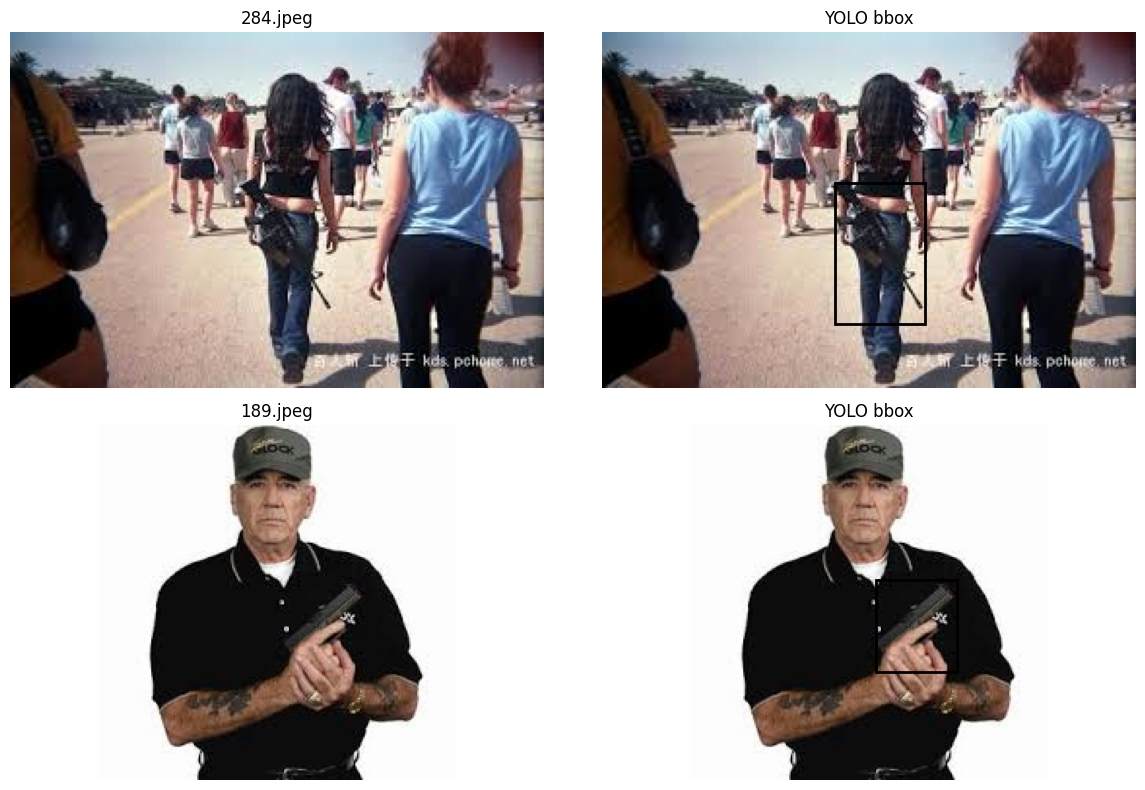

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def show_samples(n=3):
    samples = random.sample(os.listdir(train_i), n)
    plt.figure(figsize=(6*n,4*n))
    for i,fn in enumerate(samples):
        img = cv2.cvtColor(cv2.imread(os.path.join(train_i,fn)),cv2.COLOR_BGR2RGB)
        lbl = np.loadtxt(os.path.join(train_l,fn.replace(".jpeg",".txt")))
        if lbl.ndim==1: lbl=lbl[None,:]
        plt.subplot(n,2,2*i+1); plt.imshow(img); plt.axis('off'); plt.title(fn)
        plt.subplot(n,2,2*i+2); plt.imshow(img); plt.axis('off');
        h,w,_=img.shape
        for c,xc,yc,bw,bh in lbl:
            x=(xc-bw/2)*w; y=(yc-bh/2)*h
            plt.gca().add_patch(plt.Rectangle((x,y),bw*w,bh*h,fill=False,linewidth=2))
        plt.title("YOLO bbox")
    plt.tight_layout(); plt.show()

show_samples(2)


In [51]:
model = YOLO("yolov8n.pt")
results = model.train(data=os.path.join(DATASET,"guns_dataset.yaml"),
                      epochs=10, imgsz=640, name="baseline")


Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/guns-object-detection/dataset/guns_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspecti

100%|██████████| 755k/755k [00:00<00:00, 21.6MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 88.5MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 464.0±243.2 MB/s, size: 10.5 KB)


train: Scanning /content/datasets/guns-object-detection/dataset/train/labels... 266 images, 0 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:00<00:00, 2524.64it/s]

train: New cache created: /content/datasets/guns-object-detection/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 167.6±113.6 MB/s, size: 7.7 KB)


val: Scanning /content/datasets/guns-object-detection/dataset/val/labels... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<00:00, 1283.60it/s]

val: New cache created: /content/datasets/guns-object-detection/dataset/val/labels.cache


Plotting labels to runs/detect/baseline2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/baseline2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.03G      1.886      3.917      1.819         10        640: 100%|██████████| 17/17 [00:06<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all         67         84    0.00403      0.964      0.212     0.0761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.52G      1.729      3.181      1.794         20        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all         67         84    0.00751      0.881      0.417       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.54G      1.798      2.969      1.765         13        640: 100%|██████████| 17/17 [00:03<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         67         84      0.102       0.25      0.109     0.0385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.56G      1.814      2.756      1.784         13        640: 100%|██████████| 17/17 [00:03<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]

                   all         67         84      0.452     0.0476     0.0707     0.0323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.57G      1.721      2.587      1.708         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]

                   all         67         84      0.108      0.179     0.0511      0.017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       2.6G      1.741      2.537      1.836         15        640: 100%|██████████| 17/17 [00:03<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all         67         84      0.292      0.369      0.234     0.0835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.61G      1.718      2.342      1.743         12        640: 100%|██████████| 17/17 [00:03<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

                   all         67         84      0.571      0.429      0.494      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.63G      1.628      2.246      1.608         14        640: 100%|██████████| 17/17 [00:03<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.40it/s]

                   all         67         84      0.638      0.545      0.571      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.64G      1.582      2.044       1.54         12        640: 100%|██████████| 17/17 [00:03<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

                   all         67         84      0.743      0.536      0.628      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.66G      1.494      1.984      1.497         12        640: 100%|██████████| 17/17 [00:04<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         67         84      0.671      0.656      0.711       0.33



10 epochs completed in 0.015 hours.
Optimizer stripped from runs/detect/baseline2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/baseline2/weights/best.pt, 6.2MB

Validating runs/detect/baseline2/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


                   all         67         84      0.668      0.667      0.711      0.328
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/baseline2


In [52]:
metrics = model.val(data=os.path.join(DATASET,"guns_dataset.yaml"), iou=0.5)
print(f"Precision: {metrics.box.p[0]:.4f}, Recall: {metrics.box.r[0]:.4f}")
print(f"mAP@0.5: {metrics.box.map50:.4f}, mAP@0.5:0.95: {metrics.box.map:.4f}")


Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 439.6±178.9 MB/s, size: 7.4 KB)


val: Scanning /content/datasets/guns-object-detection/dataset/val/labels.cache... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


                   all         67         84      0.754      0.738      0.745       0.32
Speed: 3.0ms preprocess, 8.5ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/baseline22
Precision: 0.7539, Recall: 0.7381
mAP@0.5: 0.7454, mAP@0.5:0.95: 0.3196


### Улучшение бейзлайна

In [53]:
model = YOLO("yolov8n.pt")
model.train(
    data=os.path.join(DATASET,"guns_dataset.yaml"),
    epochs=10, imgsz=640,
    hsv_h=0.02, hsv_s=0.5, hsv_v=0.4,
    translate=0.1, scale=0.5, mosaic=1.0,
    name="tuned"
)


Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/guns-object-detection/dataset/guns_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.5, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=tuned, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.

train: Scanning /content/datasets/guns-object-detection/dataset/train/labels.cache... 266 images, 0 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 154.8±75.7 MB/s, size: 7.7 KB)


val: Scanning /content/datasets/guns-object-detection/dataset/val/labels.cache... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<?, ?it/s]


Plotting labels to runs/detect/tuned/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/tuned
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.12G       1.94      3.987       1.91         10        640: 100%|██████████| 17/17 [00:05<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         67         84    0.00363      0.869      0.165     0.0525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.28G      1.731      3.241       1.87         20        640: 100%|██████████| 17/17 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         67         84    0.00368      0.881      0.114     0.0283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.28G      1.782       2.92      1.775         13        640: 100%|██████████| 17/17 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]

                   all         67         84     0.0289     0.0595     0.0246    0.00411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.28G      1.854      2.802      1.797         13        640: 100%|██████████| 17/17 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]

                   all         67         84      0.456       0.19      0.191     0.0686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.28G      1.827      2.739      1.815         11        640: 100%|██████████| 17/17 [00:04<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         67         84      0.214      0.202      0.165     0.0677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.28G      1.744       2.53      1.828         15        640: 100%|██████████| 17/17 [00:04<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

                   all         67         84      0.274      0.262      0.186     0.0862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.28G      1.686      2.346      1.706         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.23it/s]

                   all         67         84      0.598      0.333      0.405      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.28G      1.669      2.298      1.678         14        640: 100%|██████████| 17/17 [00:03<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]

                   all         67         84      0.604      0.437      0.513      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.28G      1.558      2.072      1.581         12        640: 100%|██████████| 17/17 [00:03<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]

                   all         67         84      0.718      0.484      0.562      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.28G      1.527      1.954      1.583         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]

                   all         67         84      0.666       0.56      0.639      0.302



10 epochs completed in 0.014 hours.
Optimizer stripped from runs/detect/tuned/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/tuned/weights/best.pt, 6.2MB

Validating runs/detect/tuned/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


                   all         67         84      0.662       0.56      0.639      0.302
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/tuned


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e5bce1e2650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [54]:
m2 = model.val(data=os.path.join(DATASET,"guns_dataset.yaml"), iou=0.5)
print(f"Precision: {m2.box.p[0]:.4f}, Recall: {m2.box.r[0]:.4f}")
print(f"mAP@0.5: {m2.box.map50:.4f}, mAP@0.5:0.95: {m2.box.map:.4f}")


Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 392.8±176.7 MB/s, size: 7.4 KB)


val: Scanning /content/datasets/guns-object-detection/dataset/val/labels.cache... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


                   all         67         84      0.738      0.603       0.67      0.301
Speed: 2.8ms preprocess, 4.6ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/tuned2
Precision: 0.7378, Recall: 0.6029
mAP@0.5: 0.6699, mAP@0.5:0.95: 0.3012


### Подготовка данных и определение простой сегментационной сети
### Имплементация алгоритма машинного обучения
- **Гиперпараметры**  
  - `TARGET=(256,256)` — размер входа/выхода  
  - `LR=1e-4`, `BZ=16`, `EPOCHS=20`, `VAL_SPLIT=0.2`  

- **Класс `SegDataset`**  
  - Хранит списки изображений и масок  
  - В `__getitem__` приводит их к тензорам, нормализует `[0,1]`, ресайзит до `TARGET`  

- **Сплит и DataLoader’ы**  
  - Делим полный датасет на train/val по `VAL_SPLIT`  
  - Создаём `DataLoader` для обеих частей  

- **Взвешенный BCE (`wbce`)**  
  - Усиливает штраф за ошибки на «положительных» пикселях с весом `w=8.0`  

- **Класс `Net`**  
  - Encoder: Conv→LeakyReLU→MaxPool  
  - Decoder: Conv→LeakyReLU→Upsample→Conv→Sigmoid  
  - Выдаёт маску того же разрешения, что и вход  

- **Инициализация**  
  - Выбор `device` (CPU/GPU)  
  - Перенос модели на устройство  
  - Оптимизатор `Adam` с LR из параметров  


In [58]:
import torch, torch.nn as nn, torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np

# --- гиперпараметры ---
TARGET = (256, 256)
LR      = 1e-4
BZ      = 16
EPOCHS  = 20
VAL_SPLIT = 0.2

# --- датасет как раньше ---
class SegDataset(Dataset):
    def __init__(self, imgs, masks):
        self.imgs, self.masks = imgs, masks
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, i):
        img, m = self.imgs[i], self.masks[i]
        if isinstance(img, np.ndarray):
            img = torch.tensor(img).permute(2,0,1)
        img = img.float() / 255.0
        if isinstance(m, np.ndarray):
            m = torch.tensor(m)
        m = m.unsqueeze(0).float()
        img = F.interpolate(img.unsqueeze(0), TARGET, mode='bilinear', align_corners=False).squeeze(0)
        m   = F.interpolate(m.unsqueeze(0), TARGET, mode='nearest').squeeze(0)
        return img, m

# --- простая взвешенная BCE-функция ---
def wbce(pred, gt):
    w   = 8.0
    eps = 1e-7
    return - (w * gt * torch.log(pred + eps) + (1 - gt) * torch.log(1 - pred + eps)).mean()

# --- простая модель сегментации ---
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,5,padding=2); self.l1 = nn.LeakyReLU()
        self.pool  = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32,64,3,padding=1); self.l2 = nn.LeakyReLU()
        self.ups1  = nn.Upsample(scale_factor=2,mode='nearest')
        self.conv3 = nn.Conv2d(64,1,3,padding=1);    self.sig = nn.Sigmoid()
    def forward(self, x):
        x = self.pool(self.l1(self.conv1(x)))
        x = self.ups1(self.l2(self.conv2(x)))
        return self.sig(self.conv3(x))

# --- устройство ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- подставьте сюда ваши списки image_data и image_labels ---
full   = SegDataset(image_data, image_labels)
n      = len(full)
nv     = int(VAL_SPLIT * n)
nt     = n - nv
train_ds, val_ds = random_split(full, [nt, nv], generator=torch.Generator().manual_seed(0))
train_dl = DataLoader(train_ds, BZ, shuffle=True)
val_dl   = DataLoader(val_ds,   BZ, shuffle=False)

# --- создаём модель и оптимизатор ---
model_s = Net().to(device)
opt     = optim.Adam(model_s.parameters(), lr=LR)

# --- сам цикл обучения ---
for ep in range(1, EPOCHS+1):
    model_s.train()
    running = 0.0
    for imgs, gt in train_dl:
        imgs, gt = imgs.to(device), gt.to(device)
        pred     = model_s(imgs)
        loss     = wbce(pred, gt)
        opt.zero_grad()
        loss.backward()
        opt.step()
        running += loss.item() * imgs.size(0)
    print(f"Epoch {ep}/{EPOCHS}, Loss: {running/len(train_dl.dataset):.4f}")


Epoch 1/20, Loss: 1.3407
Epoch 2/20, Loss: 1.3360
Epoch 3/20, Loss: 1.3340
Epoch 4/20, Loss: 1.3335
Epoch 5/20, Loss: 1.3312
Epoch 6/20, Loss: 1.3302
Epoch 7/20, Loss: 1.3288
Epoch 8/20, Loss: 1.3276
Epoch 9/20, Loss: 1.3245
Epoch 10/20, Loss: 1.3234
Epoch 11/20, Loss: 1.3203
Epoch 12/20, Loss: 1.3175
Epoch 13/20, Loss: 1.3145
Epoch 14/20, Loss: 1.3114
Epoch 15/20, Loss: 1.3102
Epoch 16/20, Loss: 1.3034
Epoch 17/20, Loss: 1.3002
Epoch 18/20, Loss: 1.2964
Epoch 19/20, Loss: 1.2953
Epoch 20/20, Loss: 1.2901


In [59]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(256,256),
    A.HorizontalFlip(p=0.5),
    ToTensorV2()
])

class MosaicDS(SegDataset):
    def __getitem__(self,i):
        img, mask = super().__getitem__(i)
        if random.random()<0.5:  # обычный
            aug = transform(image=img.permute(1,2,0).numpy(), mask=mask.squeeze(0).numpy())
            return aug['image'], aug['mask'].unsqueeze(0)
        return img, mask

full2 = MosaicDS(image_data,image_labels)
nt2=int(0.8*len(full2)); nv2=len(full2)-nt2
t2,v2 = random_split(full2,[nt2,nv2])
dl2 = DataLoader(t2,BZ,shuffle=True)
v2dl = DataLoader(v2,BZ)
model_m = Net().to(device); opt = optim.Adam(model_m.parameters(),lr=LR)



In [60]:
for ep in range(EPOCHS):
    model_m.train(); running=0
    for imgs,gt in train_dl:
        imgs,gt = imgs.to(device), gt.to(device)
        pred = model_m(imgs)
        loss = wbce(pred,gt)
        opt.zero_grad(); loss.backward(); opt.step()
        running += loss.item()*imgs.size(0)
    print(f"Epoch {ep+1}/{EPOCHS}, Loss: {running/len(train_dl.dataset):.4f}")


Epoch 1/20, Loss: 1.3480
Epoch 2/20, Loss: 1.3368
Epoch 3/20, Loss: 1.3367
Epoch 4/20, Loss: 1.3345
Epoch 5/20, Loss: 1.3333
Epoch 6/20, Loss: 1.3307
Epoch 7/20, Loss: 1.3288
Epoch 8/20, Loss: 1.3264
Epoch 9/20, Loss: 1.3235
Epoch 10/20, Loss: 1.3205
Epoch 11/20, Loss: 1.3176
Epoch 12/20, Loss: 1.3136
Epoch 13/20, Loss: 1.3117
Epoch 14/20, Loss: 1.3071
Epoch 15/20, Loss: 1.3021
Epoch 16/20, Loss: 1.2994
Epoch 17/20, Loss: 1.2980
Epoch 18/20, Loss: 1.2954
Epoch 19/20, Loss: 1.2901
Epoch 20/20, Loss: 1.2856
